In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [1]:
print("="*80)
print("URBANIZATION AS ANOMALY DETECTION - OPTIMIZED ISOLATION FOREST")
print("="*80)
print("\nCONCEPT: Urban areas as spectral anomalies in vegetated landscape")
print("="*80)

URBANIZATION AS ANOMALY DETECTION - OPTIMIZED ISOLATION FOREST

CONCEPT: Urban areas as spectral anomalies in vegetated landscape


In [ ]:
# -------------------------------
# Function to compute indices
# -------------------------------
def compute_indices(b2, b3, b4, b5, b6, b7):
    ndvi = (b5 - b4) / (b5 + b4 + 1e-10)
    ndbi = (b6 - b5) / (b6 + b5 + 1e-10)
    mndwi = (b3 - b6) / (b3 + b6 + 1e-10)
    baei = (b6 + b7) / (b5 + 1e-10)
    ui = (b6 - b5) / (b6 + b5 + 1e-10)
    return ndvi, ndbi, mndwi, baei, ui

In [ ]:
# -------------------------------
# Process years
# -------------------------------
years = range(2014, 2025)
indices_data = {}
shapes = {}

print("\n1. Loading and computing spectral indices...")
for year in years:
    print(f"   Processing year {year}...")

    band2 = rasterio.open(f'Landsat8_Godavari_{year}_8SR_B2.tif')
    band3 = rasterio.open(f'Landsat8_Godavari_{year}_8SR_B3.tif')
    band4 = rasterio.open(f'Landsat8_Godavari_{year}_8SR_B4.tif')
    band5 = rasterio.open(f'Landsat8_Godavari_{year}_8SR_B5.tif')
    band6 = rasterio.open(f'Landsat8_Godavari_{year}_8SR_B6.tif')
    band7 = rasterio.open(f'Landsat8_Godavari_{year}_8SR_B7.tif')

    b2 = band2.read(1).astype('float32')
    b3 = band3.read(1).astype('float32')
    b4 = band4.read(1).astype('float32')
    b5 = band5.read(1).astype('float32')
    b6 = band6.read(1).astype('float32')
    b7 = band7.read(1).astype('float32')

    ndvi, ndbi, mndwi, baei, ui = compute_indices(b2, b3, b4, b5, b6, b7)

    indices_data[year] = {
        'NDVI': ndvi, 'NDBI': ndbi, 'MNDWI': mndwi,
        'BAEI': baei, 'UI': ui
    }
    shapes[year] = ndvi.shape


1. Loading and computing spectral indices...
   Processing year 2014...
   Processing year 2015...
   Processing year 2016...
   Processing year 2017...
   Processing year 2018...
   Processing year 2019...
   Processing year 2020...
   Processing year 2021...
   Processing year 2022...
   Processing year 2023...
   Processing year 2024...


In [ ]:
# -------------------------------
# Prepare data
# -------------------------------
print("\n2. Preparing data for Isolation Forest...")
all_indices = []
year_slices = {}
start = 0

for year in years:
    data = np.stack([
        indices_data[year]['NDVI'].flatten(),
        indices_data[year]['NDBI'].flatten(),
        indices_data[year]['MNDWI'].flatten(),
        indices_data[year]['BAEI'].flatten(),
        indices_data[year]['UI'].flatten()
    ], axis=1)

    end = start + data.shape[0]
    year_slices[year] = (start, end)
    all_indices.append(data)
    start = end

all_indices = np.vstack(all_indices)

# Analyze NDBI distribution
print(f"\n   NDBI Statistics:")
print(f"      Mean: {np.mean(all_indices[:, 1]):.4f}")
print(f"      Median: {np.median(all_indices[:, 1]):.4f}")
print(f"      Min: {np.min(all_indices[:, 1]):.4f}")
print(f"      Max: {np.max(all_indices[:, 1]):.4f}")
ndbi_positive_pct = np.sum(all_indices[:, 1] > 0) / len(all_indices) * 100
print(f"      Pixels with NDBI > 0: {np.sum(all_indices[:, 1] > 0)} ({ndbi_positive_pct:.2f}%)")
print(f"\n   → This is a VEGETATION-DOMINATED region (urban ~{ndbi_positive_pct:.1f}%)")

# Standardize
scaler = StandardScaler()
all_indices_scaled = scaler.fit_transform(all_indices)


2. Preparing data for Isolation Forest...

   NDBI Statistics:
      Mean: -0.1504
      Median: -0.1473
      Min: -0.9226
      Max: 0.3170
      Pixels with NDBI > 0: 412721 (14.95%)

   → This is a VEGETATION-DOMINATED region (urban ~14.9%)


In [ ]:
# -------------------------------
# Smart contamination range based on NDBI
# -------------------------------
# Use NDBI > 0 percentage as guide for contamination range
expected_urban_pct = ndbi_positive_pct / 100
contamination_values = [
    max(0.05, expected_urban_pct * 0.5),   # Conservative
    expected_urban_pct * 0.8,               # Moderate
    expected_urban_pct,                     # Expected
    expected_urban_pct * 1.2,               # Liberal
    min(0.3, expected_urban_pct * 1.5)     # Very liberal
]
contamination_values = sorted(list(set([round(c, 2) for c in contamination_values])))

print(f"\n3. Training Isolation Forest with smart contamination range...")
print(f"   Expected urban range: {expected_urban_pct*100:.1f}% ± 50%")
print(f"   Testing contamination values: {contamination_values}")


3. Training Isolation Forest with smart contamination range...
   Expected urban range: 14.9% ± 50%
   Testing contamination values: [np.float64(0.07), np.float64(0.12), np.float64(0.15), np.float64(0.18), np.float64(0.22)]


In [ ]:
# -------------------------------
# Train with different contaminations
# -------------------------------
results_by_contamination = {}

for contam in contamination_values:
    print(f"\n   Testing contamination = {contam:.2f}...")

    iso_forest = IsolationForest(
        contamination=contam,
        n_estimators=200,
        max_samples='auto',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    predictions = iso_forest.fit_predict(all_indices_scaled)
    anomaly_scores = iso_forest.score_samples(all_indices_scaled)

    # -1 = anomaly (potential urban), 1 = normal (non-urban)
    urban_mask = (predictions == -1)
    non_urban_mask = (predictions == 1)

    # Calculate mean indices for each class
    mean_ndbi_urban = np.mean(all_indices[urban_mask, 1])
    mean_ndbi_nonurban = np.mean(all_indices[non_urban_mask, 1])
    mean_ndvi_urban = np.mean(all_indices[urban_mask, 0])
    mean_ndvi_nonurban = np.mean(all_indices[non_urban_mask, 0])
    mean_mndwi_urban = np.mean(all_indices[urban_mask, 2])
    mean_mndwi_nonurban = np.mean(all_indices[non_urban_mask, 2])

    # Urban characteristics in vegetation-dominated regions:
    # 1. Higher NDBI (even if negative, should be less negative)
    # 2. Lower NDVI (less vegetation)
    # 3. Lower MNDWI (less water)

    ndbi_separation = mean_ndbi_urban - mean_ndbi_nonurban
    ndvi_separation = mean_ndvi_nonurban - mean_ndvi_urban  # Urban has lower NDVI
    mndwi_separation = mean_mndwi_nonurban - mean_mndwi_urban  # Urban has lower MNDWI

    # Urban quality score (all should be positive for good separation)
    urban_quality_score = (
        ndbi_separation * 2.0 +    # Weight NDBI more
        ndvi_separation * 1.5 +     # NDVI is strong indicator
        mndwi_separation * 1.0      # MNDWI helps distinguish from water
    )

    # Additional metric: what % of detected urban has NDBI > 0?
    urban_with_positive_ndbi = np.sum((predictions == -1) & (all_indices[:, 1] > 0))
    urban_positive_ndbi_pct = urban_with_positive_ndbi / np.sum(urban_mask) * 100 if np.sum(urban_mask) > 0 else 0

    print(f"      Anomalies detected: {np.sum(urban_mask)} ({np.sum(urban_mask)/len(predictions)*100:.1f}%)")
    print(f"      NDBI - Urban: {mean_ndbi_urban:.4f}, Non-Urban: {mean_ndbi_nonurban:.4f}, Δ: {ndbi_separation:+.4f}")
    print(f"      NDVI - Urban: {mean_ndvi_urban:.4f}, Non-Urban: {mean_ndvi_nonurban:.4f}")
    print(f"      MNDWI - Urban: {mean_mndwi_urban:.4f}, Non-Urban: {mean_mndwi_nonurban:.4f}")
    print(f"      Urban Quality Score: {urban_quality_score:.4f}")
    print(f"      Urban pixels with NDBI > 0: {urban_positive_ndbi_pct:.1f}%")

    results_by_contamination[contam] = {
        'predictions': predictions,
        'anomaly_scores': anomaly_scores,
        'mean_ndbi_urban': mean_ndbi_urban,
        'mean_ndbi_nonurban': mean_ndbi_nonurban,
        'mean_ndvi_urban': mean_ndvi_urban,
        'mean_ndvi_nonurban': mean_ndvi_nonurban,
        'mean_mndwi_urban': mean_mndwi_urban,
        'mean_mndwi_nonurban': mean_mndwi_nonurban,
        'urban_quality_score': urban_quality_score,
        'ndbi_separation': ndbi_separation,
        'ndvi_separation': ndvi_separation,
        'urban_percent': np.sum(urban_mask) / len(predictions) * 100,
        'urban_positive_ndbi_pct': urban_positive_ndbi_pct
    }

# Select best contamination
# Criteria: Highest urban quality score AND reasonable percentage
best_contam = max(results_by_contamination.keys(),
                  key=lambda k: results_by_contamination[k]['urban_quality_score'])

print(f"\n   ✓ Optimal contamination: {best_contam}")
print(f"   ✓ Urban areas detected: {results_by_contamination[best_contam]['urban_percent']:.2f}%")
print(f"   ✓ Urban Quality Score: {results_by_contamination[best_contam]['urban_quality_score']:.4f}")
print(f"   ✓ Urban pixels with NDBI > 0: {results_by_contamination[best_contam]['urban_positive_ndbi_pct']:.1f}%")

# Use best model
best_predictions = results_by_contamination[best_contam]['predictions']
best_anomaly_scores = results_by_contamination[best_contam]['anomaly_scores']

# Convert to binary: 1=urban (anomaly), 0=non-urban
urban_labels = (best_predictions == -1).astype(int)


   Testing contamination = 0.07...
      Anomalies detected: 193271 (7.0%)
      NDBI - Urban: -0.1318, Non-Urban: -0.1518, Δ: +0.0200
      NDVI - Urban: 0.4328, Non-Urban: 0.6224
      MNDWI - Urban: -0.3466, Non-Urban: -0.4932
      Urban Quality Score: 0.1779
      Urban pixels with NDBI > 0: 49.1%

   Testing contamination = 0.12...
      Anomalies detected: 331322 (12.0%)
      NDBI - Urban: -0.1312, Non-Urban: -0.1531, Δ: +0.0219
      NDVI - Urban: 0.4775, Non-Urban: 0.6271
      MNDWI - Urban: -0.3917, Non-Urban: -0.4954
      Urban Quality Score: 0.1643
      Urban pixels with NDBI > 0: 49.6%

   Testing contamination = 0.15...
      Anomalies detected: 414152 (15.0%)
      NDBI - Urban: -0.1340, Non-Urban: -0.1533, Δ: +0.0193
      NDVI - Urban: 0.4971, Non-Urban: 0.6289
      MNDWI - Urban: -0.4080, Non-Urban: -0.4961
      Urban Quality Score: 0.1481
      Urban pixels with NDBI > 0: 49.0%

   Testing contamination = 0.18...
      Anomalies detected: 496982 (18.0%)
      

In [ ]:
# -------------------------------
# Reshape per year
# -------------------------------
print("\n4. Creating urban maps per year...")
urban_areas = {}
anomaly_scores_maps = {}
ndbi_maps = {}

for year in years:
    start, end = year_slices[year]
    urban_areas[year] = urban_labels[start:end].reshape(shapes[year])

    # Normalize anomaly scores to 0-1 (lower score = more anomalous = more urban)
    scores = best_anomaly_scores[start:end]
    # Min-max normalization
    scores_min, scores_max = scores.min(), scores.max()
    scores_normalized = (scores_max - scores) / (scores_max - scores_min + 1e-10)
    anomaly_scores_maps[year] = scores_normalized.reshape(shapes[year])

    # Store NDBI for reference
    ndbi_maps[year] = indices_data[year]['NDBI']


4. Creating urban maps per year...


In [ ]:
# -------------------------------
# Urbanization change analysis
# -------------------------------
print("\n5. Analyzing urbanization change...")

base_year = 2014
base_urban_area = np.sum(urban_areas[base_year] == 1)
total_pixels = urban_areas[base_year].size

urban_change_cumulative = []
urban_change_yoy = []

for year in years:
    urban_area = np.sum(urban_areas[year] == 1)
    urban_pct = (urban_area / total_pixels) * 100
    base_urban_pct = (base_urban_area / total_pixels) * 100
    change = urban_pct - base_urban_pct
    urban_change_cumulative.append((year, change, urban_pct))

for i in range(1, len(years)):
    y1, y2 = years[i-1], years[i]
    u1 = np.sum(urban_areas[y1] == 1)
    u2 = np.sum(urban_areas[y2] == 1)
    pct1 = (u1 / total_pixels) * 100
    pct2 = (u2 / total_pixels) * 100
    change = pct2 - pct1
    urban_change_yoy.append((y1, y2, change))

print("\n" + "="*80)
print("URBANIZATION CHANGE RESULTS (ISOLATION FOREST)")
print("="*80)

print("\nYear-to-Year Changes:")
for y1, y2, change in urban_change_yoy:
    print(f"  {y1} → {y2}: {change:+.2f}%")

print("\nCumulative Changes from 2014:")
for year, change, total in urban_change_cumulative:
    print(f"  {year}: {change:+.2f}% (Total Urban: {total:.2f}%)")


5. Analyzing urbanization change...

URBANIZATION CHANGE RESULTS (ISOLATION FOREST)

Year-to-Year Changes:
  2014 → 2015: +4.01%
  2015 → 2016: -1.60%
  2016 → 2017: -2.26%
  2017 → 2018: +1.95%
  2018 → 2019: -0.70%
  2019 → 2020: +2.35%
  2020 → 2021: -2.25%
  2021 → 2022: -0.91%
  2022 → 2023: -1.71%
  2023 → 2024: +2.41%

Cumulative Changes from 2014:
  2014: +0.00% (Total Urban: 5.53%)
  2015: +4.01% (Total Urban: 9.54%)
  2016: +2.42% (Total Urban: 7.94%)
  2017: +0.16% (Total Urban: 5.69%)
  2018: +2.11% (Total Urban: 7.63%)
  2019: +1.41% (Total Urban: 6.94%)
  2020: +3.77% (Total Urban: 9.29%)
  2021: +1.52% (Total Urban: 7.05%)
  2022: +0.61% (Total Urban: 6.13%)
  2023: -1.10% (Total Urban: 4.42%)
  2024: +1.31% (Total Urban: 6.84%)



6. Creating comprehensive visualizations...


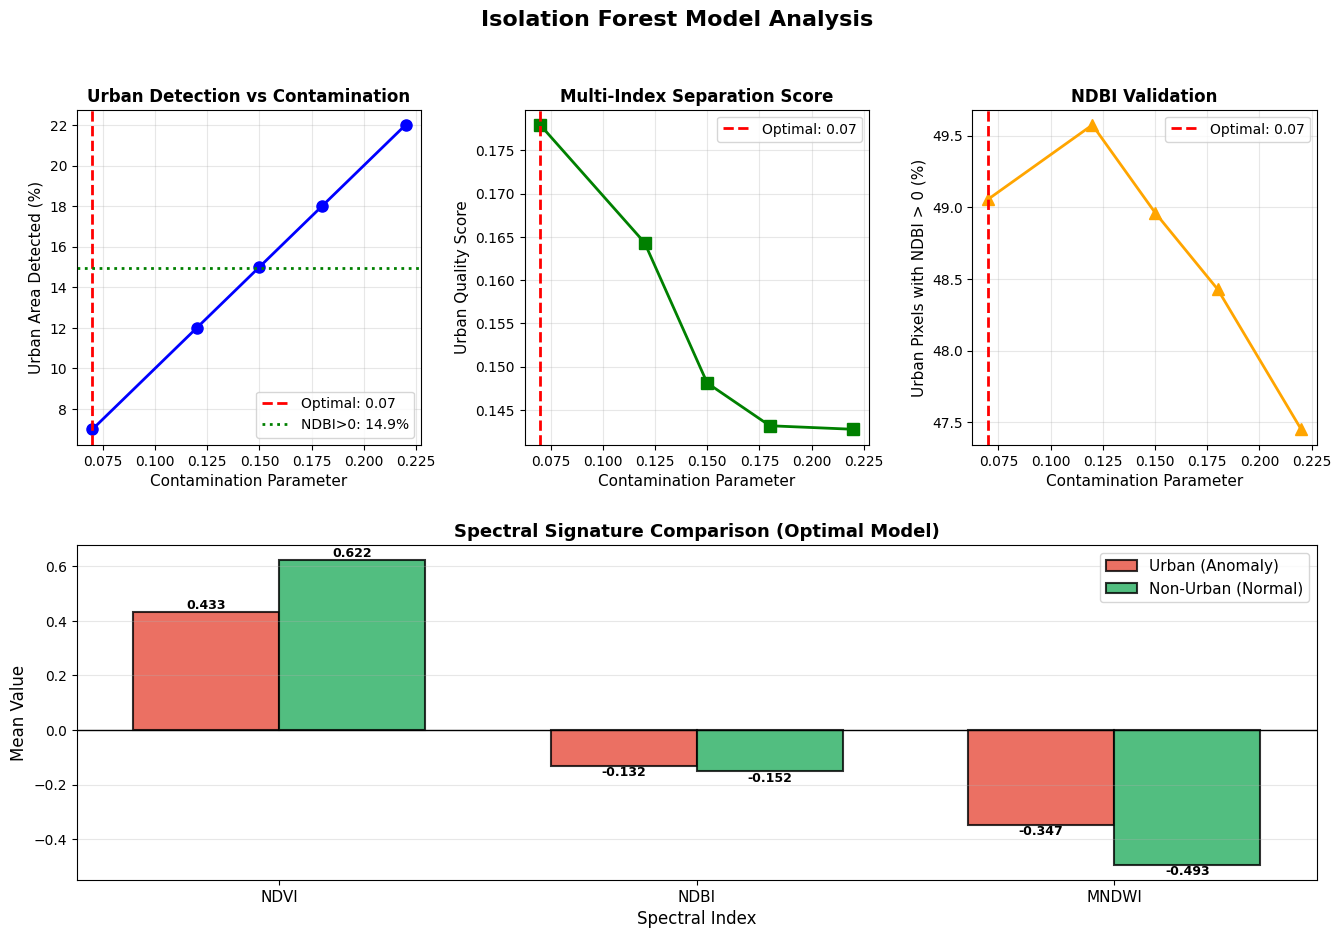

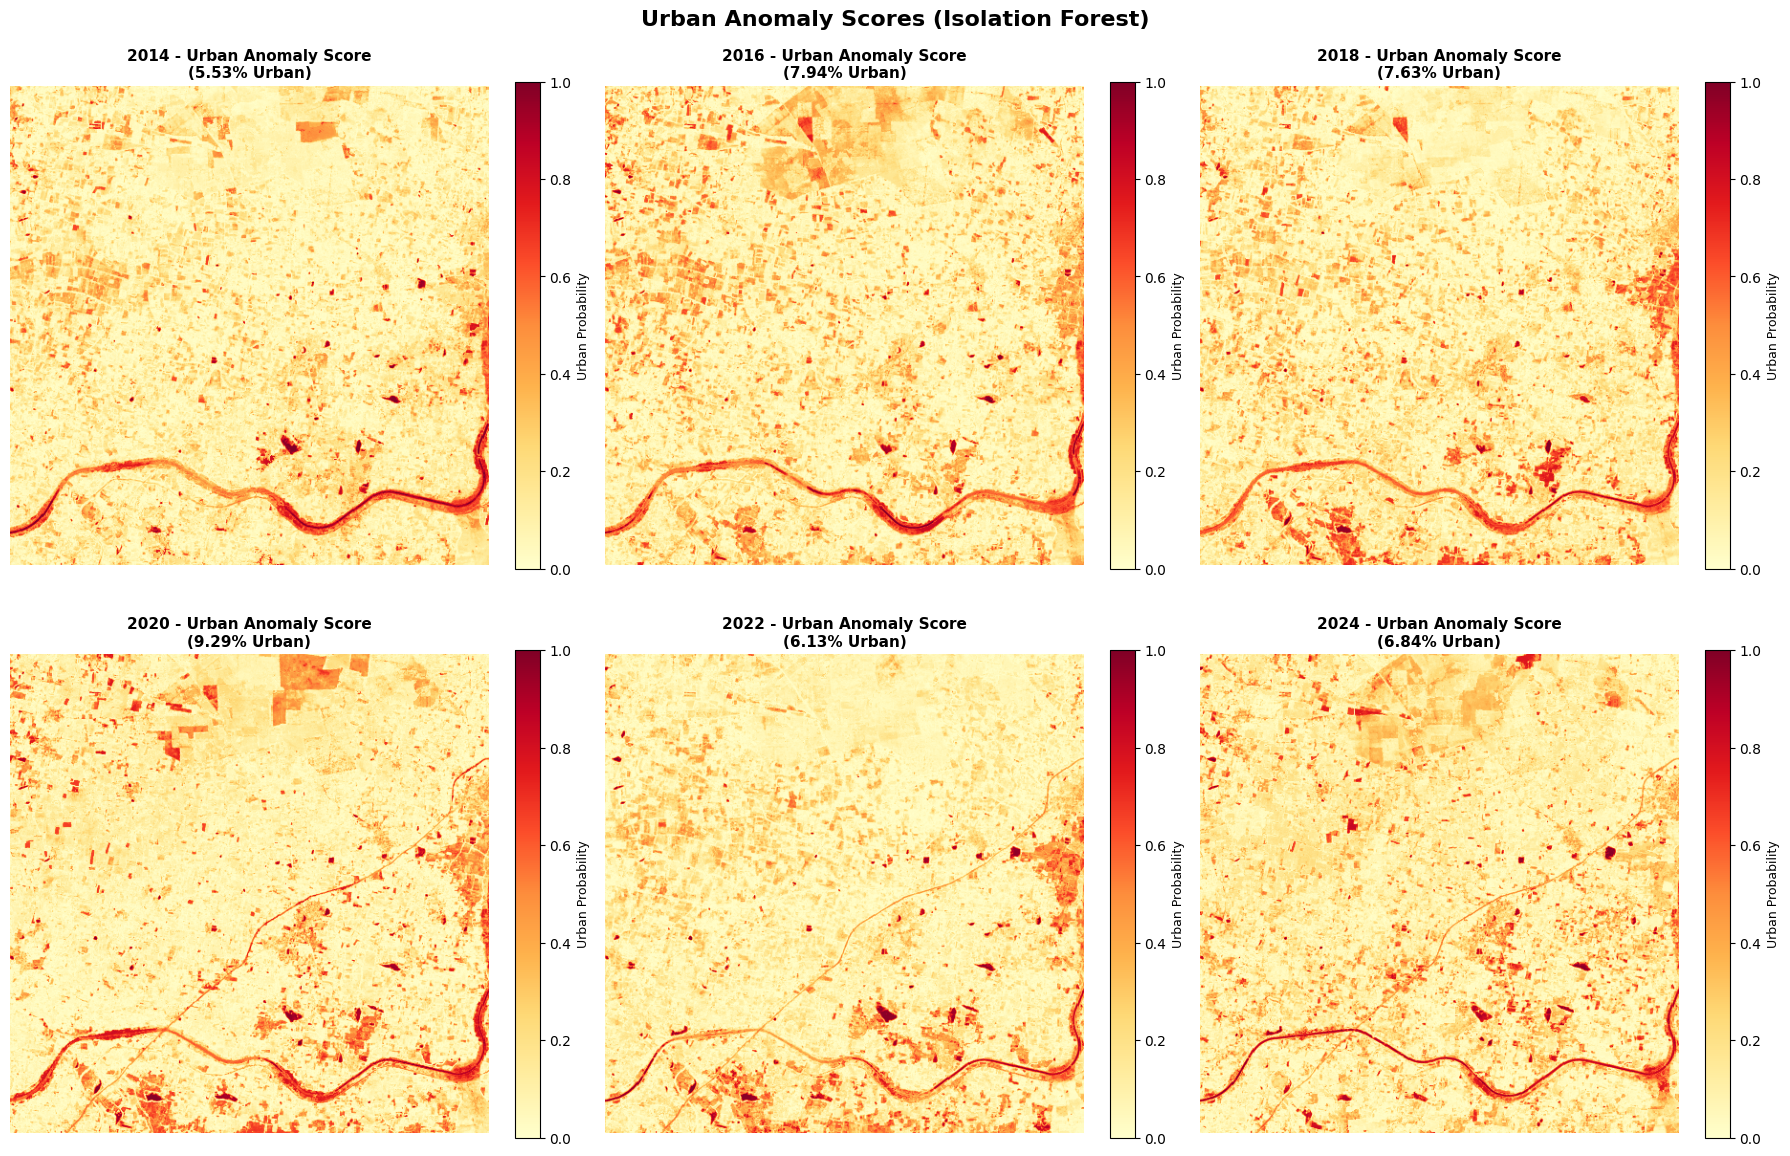

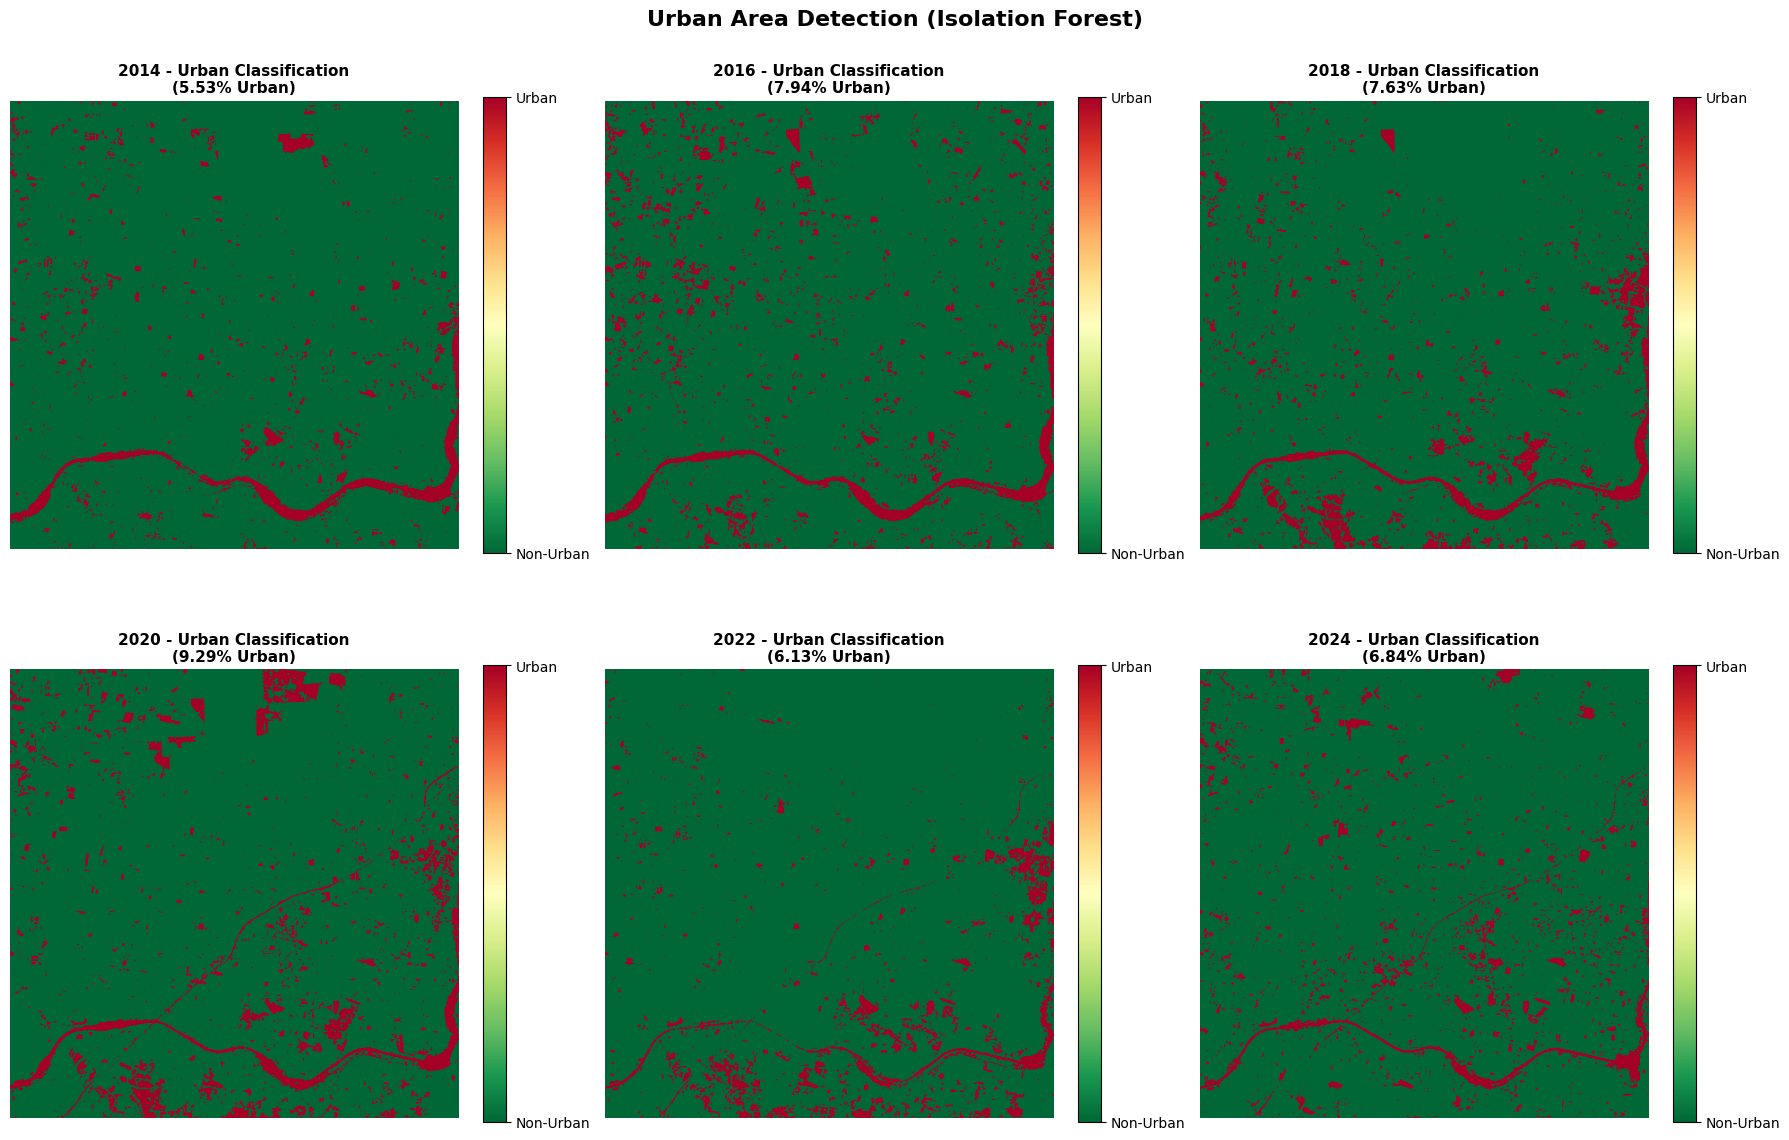

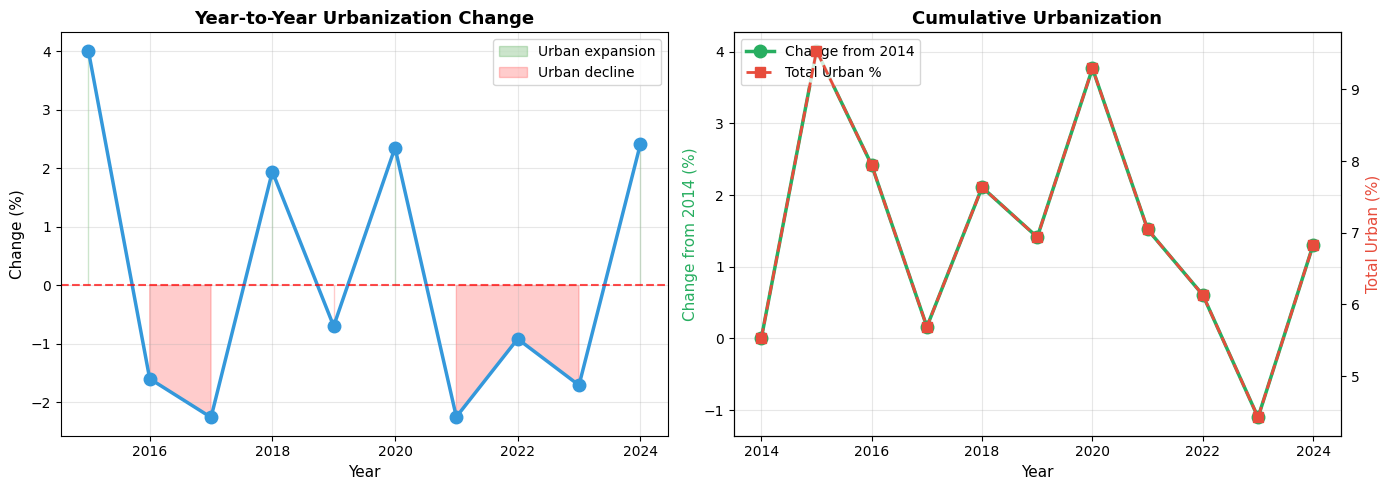

In [ ]:
# -------------------------------
# Visualizations
# -------------------------------
print("\n6. Creating comprehensive visualizations...")

# Figure 1: Model selection and spectral analysis
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Contamination vs Urban %
ax1 = fig.add_subplot(gs[0, 0])
contam_list = list(results_by_contamination.keys())
urban_pcts = [results_by_contamination[c]['urban_percent'] for c in contam_list]
ax1.plot(contam_list, urban_pcts, 'o-', linewidth=2, markersize=8, color='blue')
ax1.axvline(x=best_contam, color='red', linestyle='--', linewidth=2, label=f'Optimal: {best_contam}')
ax1.axhline(y=ndbi_positive_pct, color='green', linestyle=':', linewidth=2, label=f'NDBI>0: {ndbi_positive_pct:.1f}%')
ax1.set_xlabel('Contamination Parameter', fontsize=11)
ax1.set_ylabel('Urban Area Detected (%)', fontsize=11)
ax1.set_title('Urban Detection vs Contamination', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Urban Quality Score
ax2 = fig.add_subplot(gs[0, 1])
quality_scores = [results_by_contamination[c]['urban_quality_score'] for c in contam_list]
ax2.plot(contam_list, quality_scores, 's-', linewidth=2, markersize=8, color='green')
ax2.axvline(x=best_contam, color='red', linestyle='--', linewidth=2, label=f'Optimal: {best_contam}')
ax2.set_xlabel('Contamination Parameter', fontsize=11)
ax2.set_ylabel('Urban Quality Score', fontsize=11)
ax2.set_title('Multi-Index Separation Score', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: NDBI validation
ax3 = fig.add_subplot(gs[0, 2])
ndbi_pos_pcts = [results_by_contamination[c]['urban_positive_ndbi_pct'] for c in contam_list]
ax3.plot(contam_list, ndbi_pos_pcts, '^-', linewidth=2, markersize=8, color='orange')
ax3.axvline(x=best_contam, color='red', linestyle='--', linewidth=2, label=f'Optimal: {best_contam}')
ax3.set_xlabel('Contamination Parameter', fontsize=11)
ax3.set_ylabel('Urban Pixels with NDBI > 0 (%)', fontsize=11)
ax3.set_title('NDBI Validation', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Spectral signature comparison
ax4 = fig.add_subplot(gs[1, :])
indices_names = ['NDVI', 'NDBI', 'MNDWI']
urban_means = [
    results_by_contamination[best_contam]['mean_ndvi_urban'],
    results_by_contamination[best_contam]['mean_ndbi_urban'],
    results_by_contamination[best_contam]['mean_mndwi_urban']
]
nonurban_means = [
    results_by_contamination[best_contam]['mean_ndvi_nonurban'],
    results_by_contamination[best_contam]['mean_ndbi_nonurban'],
    results_by_contamination[best_contam]['mean_mndwi_nonurban']
]

x = np.arange(len(indices_names))
width = 0.35
bars1 = ax4.bar(x - width/2, urban_means, width, label='Urban (Anomaly)',
               color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax4.bar(x + width/2, nonurban_means, width, label='Non-Urban (Normal)',
               color='#27AE60', alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Spectral Index', fontsize=12)
ax4.set_ylabel('Mean Value', fontsize=12)
ax4.set_title('Spectral Signature Comparison (Optimal Model)', fontweight='bold', fontsize=13)
ax4.set_xticks(x)
ax4.set_xticklabels(indices_names, fontsize=11)
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')

plt.suptitle('Isolation Forest Model Analysis', fontsize=16, fontweight='bold')
plt.savefig('iforest_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Anomaly scores and NDBI comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sample_years = [2014, 2016, 2018, 2020, 2022, 2024]

for idx, year in enumerate(sample_years):
    row = idx // 3
    col = idx % 3

    im = axes[row, col].imshow(anomaly_scores_maps[year], cmap='YlOrRd', vmin=0, vmax=1)
    urban_pct = np.sum(urban_areas[year]) / urban_areas[year].size * 100
    axes[row, col].set_title(f'{year} - Urban Anomaly Score\n({urban_pct:.2f}% Urban)',
                            fontsize=11, fontweight='bold')
    axes[row, col].axis('off')
    cbar = plt.colorbar(im, ax=axes[row, col], fraction=0.046)
    cbar.set_label('Urban Probability', fontsize=9)

plt.suptitle('Urban Anomaly Scores (Isolation Forest)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('iforest_anomaly_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Binary classification
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, year in enumerate(sample_years):
    row = idx // 3
    col = idx % 3

    im = axes[row, col].imshow(urban_areas[year], cmap='RdYlGn_r', vmin=0, vmax=1)
    urban_pct = np.sum(urban_areas[year]) / urban_areas[year].size * 100
    axes[row, col].set_title(f'{year} - Urban Classification\n({urban_pct:.2f}% Urban)',
                            fontsize=11, fontweight='bold')
    axes[row, col].axis('off')
    cbar = plt.colorbar(im, ax=axes[row, col], fraction=0.046, ticks=[0, 1])
    cbar.set_ticklabels(['Non-Urban', 'Urban'])

plt.suptitle('Urban Area Detection (Isolation Forest)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('iforest_urban_classification.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4: Urbanization trends
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

years_yoy = [y2 for _, y2, _ in urban_change_yoy]
changes_yoy = [c for _, _, c in urban_change_yoy]
axes[0].plot(years_yoy, changes_yoy, 'o-', linewidth=2.5, markersize=9, color='#3498DB')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
axes[0].fill_between(years_yoy, 0, changes_yoy, where=[c > 0 for c in changes_yoy],
                     color='green', alpha=0.2, label='Urban expansion')
axes[0].fill_between(years_yoy, 0, changes_yoy, where=[c < 0 for c in changes_yoy],
                     color='red', alpha=0.2, label='Urban decline')
axes[0].set_title('Year-to-Year Urbanization Change', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Change (%)', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

years_cum = [y for y, _, _ in urban_change_cumulative]
changes_cum = [c for _, c, _ in urban_change_cumulative]
total_pcts = [t for _, _, t in urban_change_cumulative]

ax2_twin = axes[1].twinx()
line1 = axes[1].plot(years_cum, changes_cum, 'o-', linewidth=2.5, markersize=9,
                     color='#27AE60', label='Change from 2014')
line2 = ax2_twin.plot(years_cum, total_pcts, 's--', linewidth=2, markersize=7,
                      color='#E74C3C', label='Total Urban %')
axes[1].set_title('Cumulative Urbanization', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Change from 2014 (%)', fontsize=11, color='#27AE60')
ax2_twin.set_ylabel('Total Urban (%)', fontsize=11, color='#E74C3C')
axes[1].grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
axes[1].legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.savefig('iforest_urbanization_trends.png', dpi=300, bbox_inches='tight')
plt.show()

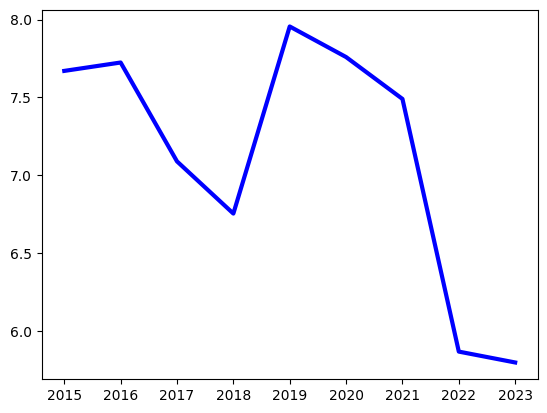

In [ ]:
# Add this to your code
years_smooth = years[1:-1]  # Exclude endpoints
urban_pct_smooth = []
for i in range(1, len(years)-1):
    avg = (urban_change_cumulative[i-1][2] +
           urban_change_cumulative[i][2] +
           urban_change_cumulative[i+1][2]) / 3
    urban_pct_smooth.append(avg)

# Plot smoothed trend
plt.plot(years_smooth, urban_pct_smooth, 'b-', linewidth=3,
         label='3-year moving average')

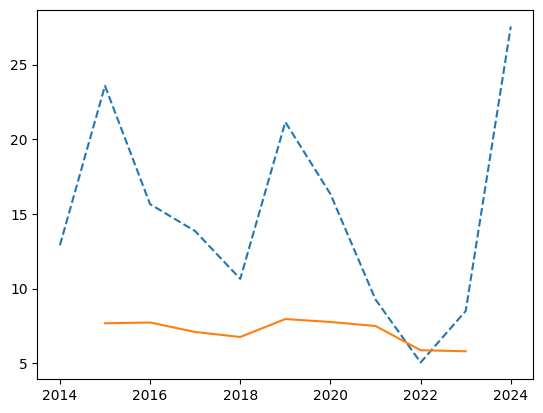

In [ ]:
ndbi_urban_pct = []
for year in years:
    ndbi = indices_data[year]['NDBI']
    urban_simple = np.sum(ndbi > 0) / ndbi.size * 100
    ndbi_urban_pct.append(urban_simple)

# Plot both
plt.plot(years, ndbi_urban_pct, label='NDBI > 0 (Simple)', linestyle='--')
plt.plot(years_smooth, urban_pct_smooth, label='Isolation Forest (Smoothed)')

# **ACCURACY**

In [ ]:
import numpy as np
import rasterio
import pandas as pd
from rasterio.transform import xy
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
# ================================================================
# STEP 1: Generate Random Sample Points
# ================================================================

print("="*80)
print("GENERATING VALIDATION SAMPLE POINTS")
print("="*80)

year = 2024

# Load your bands and read data
with rasterio.open(f'Landsat8_Godavari_{year}_8SR_B2.tif') as src:
    b2 = src.read(1).astype('float32')
    transform = src.transform
    crs = src.crs
    shape = src.shape

with rasterio.open(f'Landsat8_Godavari_{year}_8SR_B3.tif') as src:
    b3 = src.read(1).astype('float32')

with rasterio.open(f'Landsat8_Godavari_{year}_8SR_B4.tif') as src:
    b4 = src.read(1).astype('float32')

with rasterio.open(f'Landsat8_Godavari_{year}_8SR_B5.tif') as src:
    b5 = src.read(1).astype('float32')

with rasterio.open(f'Landsat8_Godavari_{year}_8SR_B6.tif') as src:
    b6 = src.read(1).astype('float32')

with rasterio.open(f'Landsat8_Godavari_{year}_8SR_B7.tif') as src:
    b7 = src.read(1).astype('float32')

# Compute indices
def compute_indices(b2, b3, b4, b5, b6, b7):
    ndvi = (b5 - b4) / (b5 + b4 + 1e-10)
    ndbi = (b6 - b5) / (b6 + b5 + 1e-10)
    mndwi = (b3 - b6) / (b3 + b6 + 1e-10)
    return ndvi, ndbi, mndwi

ndvi, ndbi, mndwi = compute_indices(b2, b3, b4, b5, b6, b7)

# Run Isolation Forest (use your optimal parameters)
data = np.stack([ndvi.flatten(), ndbi.flatten(), mndwi.flatten()], axis=1)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

iso_forest = IsolationForest(contamination=0.07, n_estimators=200, random_state=42, n_jobs=-1)
predictions = iso_forest.fit_predict(data_scaled)
urban_map = (predictions == -1).astype(int).reshape(shape)

print(f"\n✓ Classification complete")
print(f"  Urban: {np.sum(urban_map==1)} pixels ({np.sum(urban_map==1)/urban_map.size*100:.2f}%")

GENERATING VALIDATION SAMPLE POINTS

✓ Classification complete
  Urban: 17570 pixels (7.00%


In [ ]:
# ================================================================
# Generate stratified random sample
# ================================================================

n_total = 300  # You can adjust this (200-400 recommended)
n_urban = n_total // 2
n_nonurban = n_total - n_urban

urban_indices = np.argwhere(urban_map == 1)
nonurban_indices = np.argwhere(urban_map == 0)

np.random.seed(42)
urban_sample = np.random.choice(len(urban_indices), n_urban, replace=False)
nonurban_sample = np.random.choice(len(nonurban_indices), n_nonurban, replace=False)

sample_points = np.vstack([
    urban_indices[urban_sample],
    nonurban_indices[nonurban_sample]
])

print(f"\n✓ Generated {len(sample_points)} sample points:")
print(f"  Urban: {n_urban}")
print(f"  Non-urban: {n_nonurban}")


✓ Generated 300 sample points:
  Urban: 150
  Non-urban: 150


In [ ]:
# ================================================================
# Create CSV with Google Earth links
# ================================================================

data_list = []

for i, (row, col) in enumerate(sample_points):
    lon, lat = xy(transform, row, col)

    prediction = "Urban" if urban_map[row, col] == 1 else "Non-Urban"

    # Google Earth Web link
    ge_link = f"https://earth.google.com/web/@{lat},{lon},500a,500d,35y,0h,0t,0r"

    data_list.append({
        'Point_ID': i + 1,
        'Latitude': round(lat, 6),
        'Longitude': round(lon, 6),
        'Model_Prediction': prediction,
        'NDVI': round(ndvi[row, col], 4),
        'NDBI': round(ndbi[row, col], 4),
        'Google_Earth_Link': ge_link,
        'Ground_Truth': '',  # YOU WILL FILL THIS
        'Confidence': '',     # High/Medium/Low
        'Notes': ''
    })

df = pd.DataFrame(data_list)

# Save CSV
filename = f'validation_points_{year}.csv'
df.to_csv(filename, index=False)

print(f"\n✓ Saved: {filename}")


✓ Saved: validation_points_2024.csv


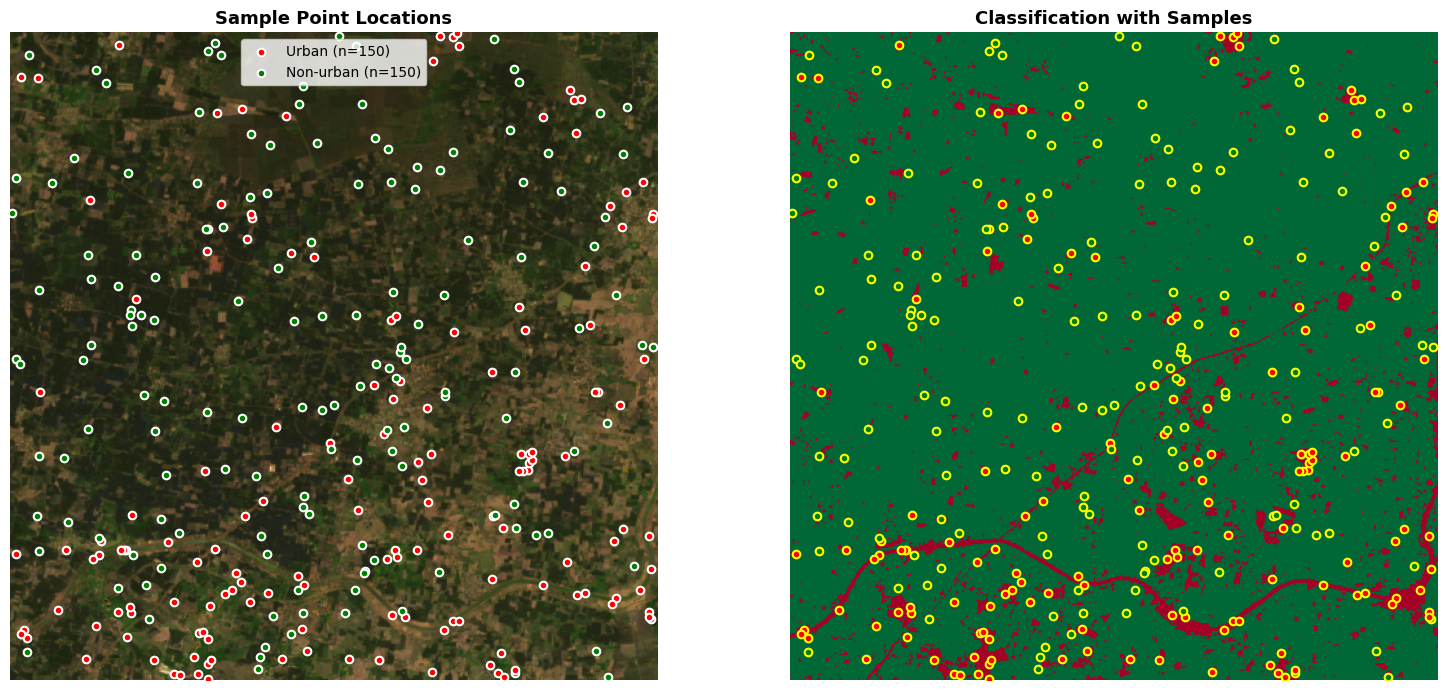

✓ Saved: sample_locations_2024.png

READY FOR MANUAL LABELING!


In [ ]:
# ================================================================
# Create visualization
# ================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# True color image
rgb = np.stack([b4, b3, b2], axis=0)
rgb = np.clip(rgb, 0, 0.3)
rgb = (rgb / 0.3 * 255).astype(np.uint8)
rgb_image = np.transpose(rgb, (1, 2, 0))

axes[0].imshow(rgb_image)
urban_pts = sample_points[urban_map[sample_points[:, 0], sample_points[:, 1]] == 1]
nonurban_pts = sample_points[urban_map[sample_points[:, 0], sample_points[:, 1]] == 0]
axes[0].scatter(urban_pts[:, 1], urban_pts[:, 0], c='red', s=30,
               label=f'Urban (n={len(urban_pts)})', edgecolors='white', linewidths=1.5)
axes[0].scatter(nonurban_pts[:, 1], nonurban_pts[:, 0], c='green', s=30,
               label=f'Non-urban (n={len(nonurban_pts)})', edgecolors='white', linewidths=1.5)
axes[0].set_title('Sample Point Locations', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].axis('off')

# Classification map
axes[1].imshow(urban_map, cmap='RdYlGn_r')
axes[1].scatter(urban_pts[:, 1], urban_pts[:, 0], c='red', s=30, edgecolors='yellow', linewidths=1.5)
axes[1].scatter(nonurban_pts[:, 1], nonurban_pts[:, 0], c='green', s=30, edgecolors='yellow', linewidths=1.5)
axes[1].set_title('Classification with Samples', fontsize=13, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(f'sample_locations_{year}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: sample_locations_{year}.png")
print("\n" + "="*80)
print("READY FOR MANUAL LABELING!")
print("="*80)